In [2]:
include("../LiPoSID.jl")

using LinearAlgebra

using DynamicPolynomials

using SymPy

using Plots

using Dates

using HDF5

data_dir = "../DATA/"

γ_list = [ "0.079477",  "0.25133", "0.79477", "2.5133", "7.9477", "25.133",  "79.477", "251.33"]

γ_list_disp = [ "0.0795",  "0.2513", "0.7947", "2.5133", "7.9477", "25.133",  "79.477", "251.33"];

b⁰ = [0, 0, 1, 1]
b¹ = [0, 0, -1, 1]
bˣ = [1, 0, 0, 1]
bʸ = [1, 1, 0, 1]


function ⊗(A::AbstractMatrix, B::AbstractMatrix)
    return kron(A,B)
end

function LME_operator_symbolic(H, J)
    
    Id = I(2)   
    U = -im*(Id ⊗ H - transpose(H) ⊗ Id)
    D = sum( 2*transpose(j')⊗j-Id⊗(j'*j) - transpose(j)*transpose(j')⊗Id for j in J )/2 
    
    Lᴸᴹᴱ = U + D
    
    return Lᴸᴹᴱ
end

function SumCoeffs2(poly, s)
    p = SymPy.expand(poly)
    rest_poly = SymPy.subs(p, s => 0)
    degrees = range(1,convert(Int32,SymPy.degree(p, s)))
    
    obj = sum(p.coeff(s^i)^2 for i in degrees) #+ rest_poly^2  
    
    return obj
end 

function sympy_to_dynamicpoly(sympy_expr::Sym) #
    # Extract variables from the SymPy expression
    vars = free_symbols(sympy_expr)

    # Convert SymPy variables to string and then to Symbol
    var_symbols = [Symbol(string(v)) for v in vars]

    # Create DynamicPolynomials variables using @polyvar macro
    @eval begin
        @polyvar $(var_symbols...)
    end

    # Map SymPy variables to DynamicPolynomials variables
    var_map = Dict(vars[i] => eval(var_symbols[i]) for i in 1:length(vars))

    # Substitute using subs and convert to DynamicPolynomial
    dynamic_poly_expr = SymPy.subs(sympy_expr, var_map)
    dynamic_poly = eval(Meta.parse(string(dynamic_poly_expr)))
    return dynamic_poly
end


function TF_objective(Aˢʸᵐᵇ, Aˢⁱᵈ, b)

    @syms s

    Gˢʸᵐᵇ = inv(I(4)*s - Aˢʸᵐᵇ)*b

    Gˢⁱᵈ = inv(I(4)*s - Aˢⁱᵈ)*b

    #ΔG = SymPy.together.(Gˢʸᵐᵇ[1:3] - Gˢⁱᵈ[1:3])
    ΔG = SymPy.together.(Gˢʸᵐᵇ - Gˢⁱᵈ)

    polys = SymPy.numerator.(ΔG)

    obj = sum(SumCoeffs2.(polys.^2, s))

    #objective = sympy_to_dynamicpoly(obj)

    return obj

end

function read_Ac(models_file_name, γ)
    h5open(models_file_name, "r") do file
        Ac = read(file["gamma_"*string(γ)]["Ac"])
        return Ac
    end
end

function dmd_Ac(γ)

    #data_dir = "../DATA/"
    data_dir = "../DATA/NO_CUT/"
    
    ρᵉ, tᵉ = LiPoSID.get_rho_series(data_dir*"State_B1_CUT_data.h5", γ) #State_B1_2CUT_data.h5
    ρᵍ, tᵍ = LiPoSID.get_rho_series(data_dir*"State_B2_CUT_data.h5", γ)
    ρˣ, tˣ = LiPoSID.get_rho_series(data_dir*"State_B3_CUT_data.h5", γ)
    ρʸ, tʸ = LiPoSID.get_rho_series(data_dir*"State_B4_CUT_data.h5", γ)

    Δt = tᵉ[2]-tᵉ[1]

    lᵉ = length(ρᵉ); lᵍ = length(ρᵍ); lˣ = length(ρˣ); lʸ = length(ρʸ)
    lᵐᵃˣ = min(lᵉ, lᵍ,  lˣ, lʸ)  #choose time limit by shortest series

    Aᴰᴹᴰ⁻ˢᴮ = LiPoSID.direct_DMD_01XY_b4_A([ρᵉ[1:lᵐᵃˣ], ρᵍ[1:lᵐᵃˣ], ρˣ[1:lᵐᵃˣ], ρʸ[1:lᵐᵃˣ]])
    Acᴰᴹᴰ⁻ˢᴮ = log(Aᴰᴹᴰ⁻ˢᴮ)/Δt

    return Acᴰᴹᴰ⁻ˢᴮ

end

function sb_TF_objective(γ, Acˢʸᵐᵇ)
    models_file_name="../MODELS/DMD_b4_LTI_trn4_2023-Nov-29_at_17-38.h5"
    Acᴰᴹᴰ = read_Ac(models_file_name, γ)
    obj =  TF_objective(Acˢʸᵐᵇ, Acᴰᴹᴰ, bˣ) + TF_objective(Acˢʸᵐᵇ, Acᴰᴹᴰ, bʸ) + TF_objective(Acˢʸᵐᵇ, Acᴰᴹᴰ, b¹) + TF_objective(Acˢʸᵐᵇ, Acᴰᴹᴰ, b⁰)
    objective = sympy_to_dynamicpoly(obj)
    return objective
end

#Functions for plotting heatmaps

function plot_TF_objective(γ, Aᴸᴹᴱ)

    objective = sb_TF_objective(γ, Aᴸᴹᴱ)

    function f(γ_val, ω_val)
        return objective(variables(objective)[1] => γ_val, variables(objective)[2] => ω_val)
    end
    
    function f(γ_val)
        return objective(variables(objective)[1] => γ_val)
    end

    γᶠ = parse(Float64, γ)

    w = range(-30, 30, length=1000)
    g = range(-30*γᶠ, 30*γᶠ, length=1000)
    #g = range(-10, 10, length=500)
    z = @. f(g', w)

    heatmap(g, w, log.(z))
    contour!(g, w, log.(z))
    title!("γ = "*string(γ))

end


function plot_TF_objective(γ, Aᴸᴹᴱ, γ_lim)

    objective = sb_TF_objective(γ, Aᴸᴹᴱ)

    function f(γ_val, ω_val)
        return objective(variables(objective)[1] => γ_val, variables(objective)[2] => ω_val)
    end
    
    function f(γ_val)
        return objective(variables(objective)[1] => γ_val)
    end

    γᶠ = parse(Float64, γ)

    w = range(-30, 10, length=1000)
    g = range(-γ_lim, γ_lim, length=1000)
    #g = range(-10, 10, length=500)
    z = @. f(g', w)

    #heatmap(g, w, log.(z))
    contour(g, w, log.(z))
    #title!("γ = "*string(γ))
    xlabel!("γ")
    ylabel!("ω")

end

plot_TF_objective (generic function with 2 methods)

In [17]:
using Optim

In [18]:
function scaling_poly(p)

    X = transpose(hcat([exponents(t) for t in terms(p)]...))

    # Get the scaling via linear regression
    scaling = X \ log.(abs.(coefficients(p)))

    exp.(abs.(scaling)) # 
end

function local_rand_min(p)

    pd = p / maximum(abs.(coefficients(p)))

    # find variable scaling
    scale = scaling_poly(pd)

    # scale the polynomial
    p_scaled = DynamicPolynomials.subs(pd, variables(pd) => scale .* variables(pd))

    num_iterations = 100

    # Initialize the best minimizer and the minimum value
    best_minimizer = nothing
    best_min_value = Inf

    num_of_variables = length(variables(pd))

    for _ in 1:num_iterations
        # Generate a random initial condition
        initial_point = rand(num_of_variables).*250

        # Run local optimization
        result = Optim.optimize(p_scaled, initial_point, BFGS())
        #println(Optim.minimum(result))

        # Update the best minimizer if a better one is found
        if Optim.minimum(result) < best_min_value
            
            best_minimizer = Optim.minimizer(result)
            best_min_value = Optim.minimum(result)
            
        end

    end

    best_minimizer = abs.(best_minimizer) # to make gamma positive

    minimizer_scaled = scale .* best_minimizer

    solution = variables(p_scaled) => minimizer_scaled

end

local_rand_min (generic function with 1 method)

In [19]:
ω = SymPy.symbols("ω", real=true)
γ = SymPy.symbols("γ", real=true)

Hᴸᴹᴱ = [ ω        0
         0        0   ]


Jᴸᴹᴱ = [ 0     γ
         0     0. + 0im  ]

Lᴸᴹᴱ = LME_operator_symbolic(Hᴸᴹᴱ, [Jᴸᴹᴱ])

M =   [ 0  0    1  1
        1  -im  0  0 
        1  im   0  0
        0  0   -1  1 ]/2

Aˢ = [ -γ/2  ω      0      0  
       -ω   -γ/2    0      0
        0    0     -γ      γ
        0    0      0      0    ] #==#

Aᴸᴹᴱ = real.(inv(M) * Lᴸᴹᴱ * M)

4×4 Matrix{Sym{PyCall.PyObject}}:
 -0.5*γ^2     1.0⋅ω         0        0
   -1.0⋅ω  -0.5*γ^2         0        0
        0         0  -1.0*γ^2  1.0*γ^2
        0         0         0        0

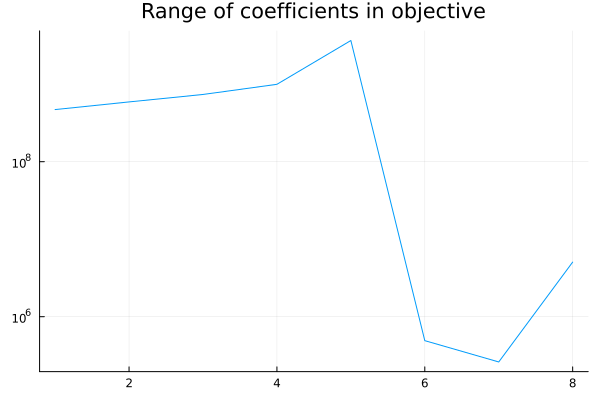

In [5]:
function coef_range(obj)
    maximum(abs.(coefficients(obj)))/minimum(abs.(coefficients(obj)))
end

coef_ranges = []

for γᵢ in  γ_list
    objective = sb_TF_objective(γᵢ, Aᴸᴹᴱ)
    push!(coef_ranges, coef_range(objective))
end
#pyplot()
plot(coef_ranges, yscale=:log10, legend=false)
title!("Range of coefficients in objective")

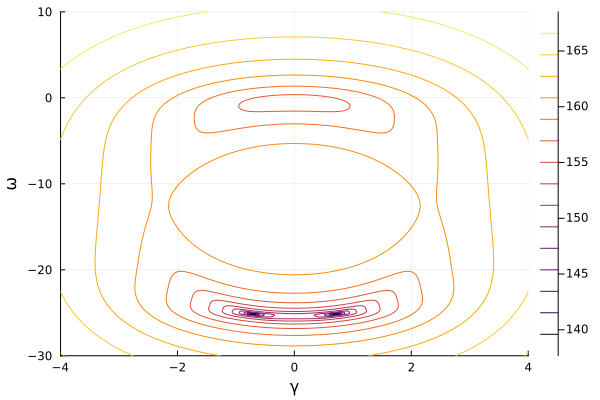

In [6]:
plot_TF_objective(γ_list[2], Aᴸᴹᴱ, 4)

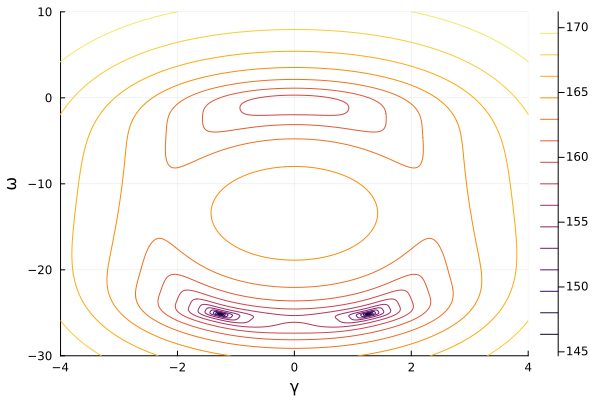

In [7]:
plot_TF_objective(γ_list[3], Aᴸᴹᴱ, 4)

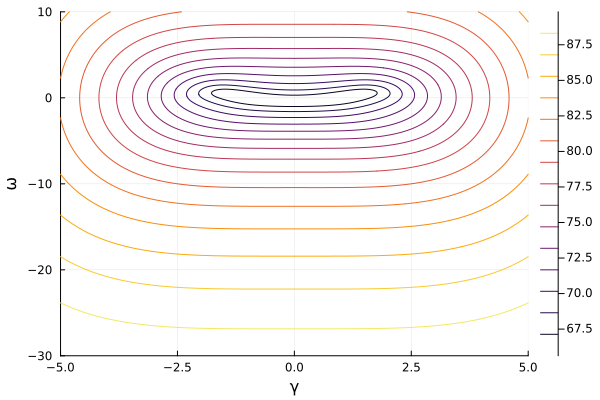

In [9]:
plot_TF_objective(γ_list[7], Aᴸᴹᴱ, 5)

In [23]:
date_and_time_string =  string(Dates.format(now(), "yyyy-u-dd_at_HH-MM"))
models_file = "DMD_TS_POP_RND_w&g2_pd_bx_"*date_and_time_string * ".h5"

models_dir = "../MODELS/"

for γᵢ in  γ_list

    println(γᵢ)

    objective = sb_TF_objective(γᵢ, Aˢ) #Aˢ Aᴸᴹᴱ

    #best_solution, best_method = LiPoSID.poly_min(objective) 


    # INSERT Random Grad Descent
    sol = local_rand_min(objective)

    println(DynamicPolynomials.subs(objective, sol))


    w = DynamicPolynomials.subs(ω, sol)
    g = DynamicPolynomials.subs(γ, sol)

    println(w)
    println(g^2)

    h5open(models_dir*models_file,"cw") do fid  # read-write, create file if not existing, preserve existing contents

        γ_group = create_group(fid, "gamma_"*γᵢ)
            
        γ_group["w"] = convert(Float64, w)
        γ_group["g"] = convert(Float64, g)
        #γ_group["best_method"] = best_method
        γ_group["coef_range"] = coef_range(objective)
                        
    end

    println()
   

end

println(models_file)

0.079477


2.9583034254233925e76
25.136499757235153
0.025922176368955187

0.25133
5.953239370736731e76


25.14667125200436
0.2514510723070091

0.79477


8.978258657179305e77
25.16332366210841
2.5125987517959714

2.5133
3.108012444922298e80


25.140026759103243
26.26194138212349

7.9477


5.663515619391513e84
24.017143035570992
293.2662919012895

25.133
4.8668286603758534e30


0.16699261268884036
1.3672573987181205

79.477


8.092257918528018e30
0.20867512124838353
1.589533607812391

251.33
3.523438900600374e32


0.253874164903272
0.16684270800377748

DMD_TS_POP_RND_w&g2_pd_bx_2024-Jan-31_at_16-14.h5
